**References:** 

1. [DEAP: A Database for Emotion Analysis using Physiological Signals](https://www.eecs.qmul.ac.uk/mmv/datasets/deap/doc/tac_special_issue_2011.pdf)

2. [Online Prediction of Driver Distraction Based on Brain Activity Patterns](https://www.researchgate.net/publication/267154789_Online_Prediction_of_Driver_Distraction_Based_on_Brain_Activity_Patterns)

3. [Emotion Recognition with Machine Learning Using EEG Signals](https://arxiv.org/pdf/1903.07272.pdf)

4. [EEG Correlates of Different Emotional States Elicited during Watching Music Videos](https://www.researchgate.net/publication/221622214_EEG_Correlates_of_Different_Emotional_States_Elicited_during_Watching_Music_Videos)

5. [The Effect of Transcranial Magnetic Stimulation on Brain Electrical Activity](https://www.researchgate.net/publication/267811728_THE_EFFECT_OF_TRANSCRANIAL_MAGNETIC_STIMULATION_ON_BRAIN_BIOELECTRICAL_ACTIVITY)

**Original dataset:** 

The dataset is mounted from our Google Drive and could be downloaded [here](https://www.eecs.qmul.ac.uk/mmv/datasets/deap/download.html). 

In [1]:
import time
import pickle
import pandas as pd
import numpy as np

In [2]:
from scipy.signal import welch
from scipy.integrate import simps

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import model_selection
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


import matplotlib.pyplot as plt

# Load dataset
The EEG and peripheral physiological signals of 32 participants were recorded as each watched 40 music videos. Participants rated each video in terms of the levels of arousal, valence, dominance, and liking. The data was downsampled (to 128Hz), preprocessed and segmented in pickled Python formats.

In [3]:
# Function to load data from each participant file
def read_eeg_signal_from_file(filename):
    x = pickle._Unpickler(open(filename, 'rb'))
    x.encoding = 'latin1'
    p = x.load()
    return p

In [4]:
# Load only 22/32 participants with frontal videos recorded
files = []
for n in range(1, 23): 
    s = ''
    if n < 10:
        s += '0'
    s += str(n)
    files.append(s)

Each participant file contains two arrays: a "data" array (40 trials x 40 channels x 8064 data) and a "label" array (40 trials x 4 subjective ratings: valence, arousal, dominance, liking). We combine the data files into 2 new arrays with 880 trials for 22/32 participants (participants with frontal videos recorded).

In [5]:
# 22x40 = 880 trials for 22 participants
labels = []
data = []

for i in files: 
  filename = "./eeg_data/s" + i + ".dat"
  trial = read_eeg_signal_from_file(filename)
  labels.append(trial['labels'])
  data.append(trial['data'])

# Re-shape arrays into desired shapes
labels = np.array(labels)
labels = labels.flatten()
labels = labels.reshape(880, 4)

In [6]:
data = np.array(data)
data = data.flatten()
data = data.reshape(880, 40, 8064)


# Explore and pre-process data

## Labels

#### Get Valence and Arousal ratings
Valence describes the extent to which an emotion is positive or negative, whereas Arousal refers to its intensity, i.e., the strength of the associated emotional state.

#### Check positive/negative cases

The combinations of Valence and Arousal can be converted to emotional states: High Arousal Positive Valence (Excited, Happy), Low Arousal Positive Valence (Calm, Relaxed), High Arousal Negative Valence (Angry, Nervous), and Low Arousal Negative Valence (Sad, Bored).

#### One hot encoding

In [7]:
# Function to check if each trial has positive or negative valence
def positive_valence(trial):
    return 1 if labels[trial,0] >= np.median(labels[:,0]) else 0 
# Function to check if each trial has high or low arousal
def high_arousal(trial):
    return 1 if labels[trial,1] >= np.median(labels[:,1]) else 0

In [8]:
# Convert all ratings to boolean values
labels_encoded = []
for i in range (len(labels)):
  labels_encoded.append([positive_valence(i), high_arousal(i)])
labels_encoded = np.reshape(labels_encoded, (880, 2))
df_labels = pd.DataFrame(data=labels_encoded, columns=["Positive Valence", "High Arousal"])
print(df_labels.describe())

       Positive Valence  High Arousal
count        880.000000    880.000000
mean           0.519318      0.502273
std            0.499911      0.500279
min            0.000000      0.000000
25%            0.000000      0.000000
50%            1.000000      1.000000
75%            1.000000      1.000000
max            1.000000      1.000000


In [9]:
# Dataset with only Valence column
df_valence = df_labels['Positive Valence']
# Dataset with only Arousal column
df_arousal = df_labels['High Arousal']

## EEG data

### Separate EEG and non-EEG data

The dataset includes 32 EEG channels and 8 peripheral physiological channels. The peripheral signals include: electrooculogram (EOG), electromyograms (EMG) of Zygomaticus and Trapezius muscles, GSR, respiration amplitude, blood volume by plethysmograph, skin temperature.

In [10]:
eeg_channels = np.array(["Fp1", "AF3", "F3", "F7", "FC5", "FC1", "C3", "T7", "CP5", "CP1", "P3", "P7", "PO3", "O1", "Oz", "Pz", "Fp2", "AF4", "Fz", "F4", "F8", "FC6", "FC2", "Cz", "C4", "T8", "CP6", "CP2", "P4", "P8", "PO4", "O2"])

In [11]:
eeg_data = []
print(len(data))
for i in range (len(data)):
  for j in range (len(eeg_channels)):
    eeg_data.append(data[i,j])
eeg_data = np.reshape(eeg_data, (len(data), len(eeg_channels), len(data[0,0])))
print(eeg_data.shape)

880
(880, 32, 8064)


### Welch's feature extraction

For the EEG data, we use Welch's method to extract theta, alpha, beta, and gamma spectral
power for each electrode. The frequency bands used:
theta (4 - 8 Hz), alpha (8 - 12 Hz), beta (12 - 30 Hz),
and gamma (30 - 64 Hz).

#### Gamma band power

#### Functions to get band power values

In [12]:
"""Compute the average power of the signal x in a specific frequency band.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds.
        If None, window_sec = (1 / min(band)) * 2
    relative : boolean
        If True, return the relative power (= divided by the total power of the signal).
        If False (default), return the absolute power.

    Return
    ------
    bp : float
        Absolute or relative band power.
    """
def bandpower(data, sf, band, window_sec=None, relative=False):
    band = np.asarray(band)
    low, high = band

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=nperseg)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

In [13]:
def get_band_power(trial, channel, band):
  bd = (0,0)

  if band == "theta": # drownsiness, emotional connection, intuition, creativity
    bd = (4,8)
  elif band == "alpha": # reflection, relaxation
    bd = (8,12)
  elif band == "beta": # concentration, problem solving, memory
    bd = (12,30)
  elif band == "gamma": # cognition, perception, learning, multi-tasking
    bd = (30,64)
  
  return bandpower(eeg_data[trial,channel], 128, bd)

print(get_band_power(0,31,"theta"))
print(get_band_power(0,31,"alpha"))
print(get_band_power(0,31,"beta"))
print(get_band_power(0,31,"gamma"))

5.434119660168186
5.369595513295193
6.286556266834863
0.9879159580139809


### Process new datasets with 6 EEG regions and 4 band power values

In [14]:
# Transform 880 x 32 x 8064 => 880 x 128
eeg_band_arr = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_band_arr.append(get_band_power(i,j,"theta"))
    eeg_band_arr.append(get_band_power(i,j,"alpha"))
    eeg_band_arr.append(get_band_power(i,j,"beta"))
    eeg_band_arr.append(get_band_power(i,j,"gamma"))
eeg_band_arr = np.reshape(eeg_band_arr, (880, 128))

EEG channels are divided into 6 groups, according to their cerebral spatial locations. We combine the temmporal-left and temporal-right channels into the left and right groups. The frontal group only includes the fronto-central channels. All centro-parietal channels are included in the central group.

In [15]:
left = np.array(["Fp1", "AF3", "F7", "FC5", "T7"])
right = np.array(["Fp2", "AF4", "F8", "FC6", "T8"])
frontal = np.array(["F3", "FC1", "Fz", "F4", "FC2"])
parietal = np.array(["P3", "P7", "Pz", "P4", "P8"])
occipital = np.array(["O1", "Oz", "O2", "PO3", "PO4"])
central = np.array(["CP5", "CP1", "Cz", "C4", "C3", "CP6", "CP2"])

#### Dataframe for Theta power values

In [16]:
# Transform 880 x 32 x 8064 => 880 x 32 
eeg_theta = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_theta.append(get_band_power(i,j,"theta"))
eeg_theta = np.reshape(eeg_theta, (880, 32))

df_theta = pd.DataFrame(data = eeg_theta, columns=eeg_channels)
print(df_theta.describe())

                Fp1           AF3            F3            F7           FC5  \
count    880.000000    880.000000    880.000000    880.000000    880.000000   
mean     547.699828   1275.383637    961.474061   2081.240523    946.543725   
std     1217.588842   3736.181334   3558.843893   5918.701828   2572.974374   
min        2.698928      3.034321      3.150251      3.633784      1.897310   
25%       24.093211     18.601381     22.046306     39.123277     13.872183   
50%       58.450614     72.755754     73.991298    105.346160     43.000439   
75%      366.274753    313.477898    196.346622    278.757018    256.012013   
max    15524.135098  38122.870846  39431.320394  49272.793208  20182.668545   

               FC1            C3           T7           CP5          CP1  ...  \
count   880.000000    880.000000   880.000000    880.000000   880.000000  ...   
mean    335.659847    629.689546   384.184590    437.472694   278.676186  ...   
std     714.083236   1774.585233   690.041682

#### Dataframe for Alpha power values

In [17]:
# Transform 880 x 32 x 8064 => 880 x 32 
eeg_alpha = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_alpha.append(get_band_power(i,j,"alpha"))
eeg_alpha = np.reshape(eeg_alpha, (880, 32))

df_alpha = pd.DataFrame(data = eeg_alpha, columns=eeg_channels)
print(df_alpha.describe())

               Fp1           AF3            F3            F7          FC5  \
count   880.000000    880.000000    880.000000    880.000000   880.000000   
mean    182.780787    433.010540    341.730793    787.400910   314.738809   
std     397.609258   1257.592452   1216.972362   2308.043683   825.808971   
min       2.770151      2.600120      2.465953      2.797222     1.834374   
25%      14.191465     11.606644     11.980286     20.273524    10.026005   
50%      33.255285     30.578066     34.808317     43.435592    18.695757   
75%     143.122306    113.219878     76.686527     98.532143    80.893786   
max    5627.906982  12380.702125  12764.724842  20843.070851  6575.781434   

               FC1           C3           T7          CP5          CP1  ...  \
count   880.000000   880.000000   880.000000   880.000000   880.000000  ...   
mean    121.280044   217.799701   134.574741   152.678807    97.400749  ...   
std     239.498196   589.217906   212.290931   453.804808   170.99737

#### Dataframe for Beta power values

In [18]:
# Transform 880 x 32 x 8064 => 880 x 32 
eeg_beta = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_beta.append(get_band_power(i,j,"beta"))
eeg_beta = np.reshape(eeg_beta, (880, 32))

df_beta = pd.DataFrame(data = eeg_beta, columns=eeg_channels)
print(df_beta.describe())

               Fp1          AF3           F3            F7          FC5  \
count   880.000000   880.000000   880.000000    880.000000   880.000000   
mean    101.611223   263.952803   235.508477    465.399568   179.789592   
std     198.334644   796.392259   788.367310   1519.021099   458.150537   
min       4.833550     4.883739     2.784376      3.363422     2.788531   
25%      18.086819    11.982996    10.729005     22.091801    11.204561   
50%      34.722505    25.125524    36.282166     38.288488    24.475747   
75%      85.835547   126.899960    60.713457     66.695440    51.443774   
max    3528.485435  5784.160193  5841.475721  14848.700463  3094.687504   

               FC1           C3          T7          CP5          CP1  ...  \
count   880.000000   880.000000  880.000000   880.000000   880.000000  ...   
mean     79.068918   122.401946   88.356066   100.541065    56.115746  ...   
std     143.006705   292.628142   98.997184   300.750517    91.929062  ...   
min       3.

#### Dataframe for Gamma power values

In [19]:
# Transform 880 x 32 x 8064 => 880 x 32 
eeg_gamma = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_gamma.append(get_band_power(i,j,"gamma"))
eeg_gamma = np.reshape(eeg_gamma, (880, 32))

df_gamma = pd.DataFrame(data = eeg_gamma, columns=eeg_channels)
print(df_gamma.describe())

               Fp1          AF3           F3           F7          FC5  \
count   880.000000   880.000000   880.000000   880.000000   880.000000   
mean     64.360730   209.707060   194.609476   159.941476   124.196535   
std     161.216361   771.449190   753.374704   592.830844   406.399270   
min       1.069233     1.119910     0.791859     1.177512     0.712624   
25%       9.012946     5.500269     5.077370    11.192724     5.261965   
50%      20.679781    14.559035    15.403148    18.490352    13.541378   
75%      48.359529    74.742440    38.093791    43.985629    44.548886   
max    3213.255538  6060.539788  5758.756812  6348.177208  3472.515858   

               FC1           C3          T7          CP5          CP1  ...  \
count   880.000000   880.000000  880.000000   880.000000   880.000000  ...   
mean     56.189659    74.570798   53.296388    80.533037    32.725472  ...   
std     141.231111   214.343252   71.234263   292.089404    77.716661  ...   
min       0.694928   

# Train-test split and feature scaling

In [20]:
# Split the data into training/testing sets
def split_train_test(x, y):
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)
  return x_train, x_test, y_train, y_test

In [21]:
# Feature scaling
def feature_scaling(train, test):
  sc = StandardScaler()
  train = sc.fit_transform(train)
  test = sc.transform(test)
  return train, test

# Cross-validation to select classifier

In [22]:
band_names = np.array(["theta", "alpha", "beta", "gamma"])
channel_names = np.array(["left", "frontal", "right", "central", "parietal", "occipital"])
label_names = np.array(["valence", "arousal"])

In [23]:
# Testing different kernels (linear, sigmoid, rbf, poly) to select the most optimal one
clf_svm = SVC(kernel = 'linear', random_state = 42, probability=True)

In [24]:
# Testing different k (odd) numbers, algorithm (auto, ball_tree, kd_tree) and weight (uniform, distance) to select the most optimal one
clf_knn = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='auto')

In [25]:
# Testing different learning rate (alpha), solver (adam, sgd, lbfgs) and activation (relu, tanh, logistic) to select the most optimal one
clf_mlp = MLPClassifier(solver='adam', activation='tanh', alpha=0.3, max_iter=400)

In [26]:
models = []
models.append(('SVM', clf_svm))
models.append(('k-NN', clf_knn))
models.append(('MLP', clf_mlp))

In [27]:
def cross_validate_clf(df_x, df_y, scoring):
  # Train-test split 
  x_train, x_test, y_train, y_test = split_train_test(df_x, df_y)
  # Feature scaling
  x_train, x_test = feature_scaling(x_train, x_test)

  names = []
  means = []
  stds = []
  times = []

  # Apply CV
  for name, model in models:
      start_time = time.time()
      kfold = model_selection.KFold(n_splits=5)
      cv_results = model_selection.cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
      t = (time.time() - start_time)
      times.append(t)
      means.append(cv_results.mean())
      stds.append(cv_results.std())
      names.append(name)

  return names, means, stds, times

### Arousal - Accuracy

In [28]:
cross_validate_clf(eeg_band_arr, df_arousal, 'accuracy')

(['SVM', 'k-NN', 'MLP'],
 [0.5827432467873066, 0.582690794649882, 0.5843168109100445],
 [0.032101393745388146, 0.04431488605048775, 0.03778702364073061],
 [0.43918418884277344, 0.18686795234680176, 4.128681898117065])

### Arousal - F1

In [29]:
cross_validate_clf(eeg_band_arr, df_arousal, 'f1')

(['SVM', 'k-NN', 'MLP'],
 [0.5937644626169215, 0.5894382544174931, 0.6013173685666102],
 [0.06306024032148098, 0.05063265884937661, 0.056864321012490386],
 [0.529728889465332, 0.01907205581665039, 3.6961710453033447])

### Valence - Accuracy

In [30]:
cross_validate_clf(eeg_band_arr, df_valence, 'accuracy')

(['SVM', 'k-NN', 'MLP'],
 [0.5748360870705481, 0.6168895882507213, 0.6284028324154209],
 [0.05271530492570222, 0.044277309553946674, 0.08191331253157647],
 [0.5725991725921631, 0.016885995864868164, 5.011868238449097])

### Valence - F1

In [31]:
cross_validate_clf(eeg_band_arr, df_valence, 'f1')

(['SVM', 'k-NN', 'MLP'],
 [0.5663061143466444, 0.6284944434096976, 0.6668000016481457],
 [0.05453809485526526, 0.05807541894297642, 0.07656197784213717],
 [0.5597858428955078, 0.015308856964111328, 4.509238958358765])

# Apply classifier

## Functions to run classifiers

In [32]:
def run_clf_cv(band, channel, label, clf):
  if band == "theta":
    df_x = df_theta
  elif band == "alpha":
    df_x = df_alpha
  elif band == "beta":
    df_x = df_beta
  elif band == "gamma":
    df_x = df_gamma

  if channel == "left":
    df_x = df_x[left]
  elif channel == "right":
    df_x = df_x[right]
  elif channel == "frontal":
    df_x = df_x[frontal]
  elif channel == "central":
    df_x = df_x[central]
  elif channel == "parietal":
    df_x = df_x[parietal]
  elif channel == "occipital":
    df_x = df_x[occipital]

  df_y = df_arousal if (label == "arousal") else df_valence

  # Train-test split
  x_train, x_test, y_train, y_test = split_train_test(df_x, df_y)
  
  # Apply CV
  x_for_kfold = np.array(x_train)            
  y_for_kfold = np.array(y_train)
  kfold = model_selection.KFold(n_splits=5)

  for i, j in kfold.split(x_for_kfold):
   x_train2, x_test2 = x_for_kfold[i], x_for_kfold[j]
   y_train2, y_test2 = y_for_kfold[i], y_for_kfold[j]
  
  # Feature scaling
  x_train2, x_test2 = feature_scaling(x_train2, x_test2)

  if clf == "svm":
    clf_svm.fit(x_train2, y_train2)
    y_predict = clf_svm.predict(x_test2)
  elif clf == "knn":
    clf_knn.fit(x_train2, y_train2)
    y_predict = clf_knn.predict(x_test2)
  elif clf == "mlp":
    clf_mlp.fit(x_train2, y_train2)
    y_predict = clf_mlp.predict(x_test2)

  return y_test2, y_predict

In [33]:
def get_accuracy(band, channel, label, clf):
  y_test2, y_predict = run_clf_cv(band, channel, label, clf)
  return np.round(accuracy_score(y_test2, y_predict)*100,2)

In [34]:
def print_accuracy(label, clf):
  arr = []
  for i in range (len(band_names)):
    for j in range (len(channel_names)): 
      arr.append(get_accuracy(band_names[i], channel_names[j], label, clf))
  arr = np.reshape(arr, (4,6))
  df = pd.DataFrame(data = arr, index=band_names, columns=channel_names)

  print("Top 3 EEG regions with highest scores")
  print(df.apply(lambda s: s.abs()).max().nlargest(3))
  print()
  print("Top 2 bands with highest scores")
  print(df.apply(lambda s: s.abs()).max(axis=1).nlargest(2))
  print()
  print("EEG region with highest scores per each band")
  print(df.idxmax(axis=1))
  print()
  print("Band with highest scores per each EEG region")
  print(df.idxmax())
  print()
  print(df)

In [35]:
def get_f1(band, channel, label, clf):
  y_test2, y_predict = run_clf_cv(band, channel, label, clf)
  return np.round(f1_score(y_test2, y_predict)*100,2)

In [36]:
def print_f1(label, clf):
  arr = []
  for i in range (len(band_names)):
    for j in range (len(channel_names)): 
      arr.append(get_f1(band_names[i], channel_names[j], label, clf))
  arr = np.reshape(arr, (4,6))
  df = pd.DataFrame(data = arr, index=band_names, columns=channel_names)

  print("Top 3 EEG regions with highest scores")
  print(df.apply(lambda s: s.abs()).max().nlargest(3))
  print()
  print("Top 2 bands with highest scores")
  print(df.apply(lambda s: s.abs()).max(axis=1).nlargest(2))
  print()
  print("EEG region with highest scores per each band")
  print(df.idxmax(axis=1))
  print()
  print("Band with highest scores per each EEG regions")
  print(df.idxmax())
  print()
  print(df)

In [37]:
def plot_cm(band, channel, label, clf):
  y_test2, y_predict = run_clf_cv(band, channel, label, clf)
  cm = confusion_matrix(y_test2, y_predict)
  print(cm)
  cr = classification_report(y_test2, y_predict)
  print(cr)

  plt.figure()
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.colorbar()

  if label == "valence":
    classes = df_valence.unique().tolist()
  if label == "arousal":
    classes = df_arousal.unique().tolist()

  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], 'd'),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')


## Accuracy results

### Valence

In [38]:
# Only use k-NN in case of Valence after CV
print_accuracy('valence', 'knn')

Top 3 EEG regions with highest scores
left       69.11
right      68.29
central    67.48
dtype: float64

Top 2 bands with highest scores
beta     69.11
gamma    68.29
dtype: float64

EEG region with highest scores per each band
theta    central
alpha    central
beta        left
gamma      right
dtype: object

Band with highest scores per each EEG region
left          beta
frontal       beta
right        gamma
central      theta
parietal      beta
occipital     beta
dtype: object

        left  frontal  right  central  parietal  occipital
theta  56.91    63.41  57.72    67.48     56.91      55.28
alpha  58.54    52.85  60.16    65.85     62.60      55.28
beta   69.11    64.23  65.85    59.35     64.23      63.41
gamma  59.35    61.79  68.29    61.79     60.98      62.60


### Arousal

In [39]:
# Only use MLP in case of Arousal after CV
print_accuracy('arousal', 'mlp')

Top 3 EEG regions with highest scores
left        60.98
parietal    60.98
frontal     57.72
dtype: float64

Top 2 bands with highest scores
theta    60.98
gamma    60.98
dtype: float64

EEG region with highest scores per each band
theta    parietal
alpha    parietal
beta     parietal
gamma        left
dtype: object

Band with highest scores per each EEG region
left         gamma
frontal      theta
right        theta
central      theta
parietal     theta
occipital    alpha
dtype: object

        left  frontal  right  central  parietal  occipital
theta  52.85    57.72  52.03    56.10     60.98      52.03
alpha  50.41    55.28  51.22    55.28     56.91      52.85
beta   51.22    50.41  47.15    52.03     59.35      46.34
gamma  60.98    48.78  45.53    51.22     60.16      42.28


## F1 score results

### Valence

In [40]:
# Only use k-NN in case of Valence after CV
print_f1('valence', 'knn')

Top 3 EEG regions with highest scores
right      72.34
central    71.83
left       69.35
dtype: float64

Top 2 bands with highest scores
gamma    72.34
theta    71.83
dtype: float64

EEG region with highest scores per each band
theta    central
alpha    central
beta       right
gamma      right
dtype: object

Band with highest scores per each EEG regions
left          beta
frontal      theta
right        gamma
central      theta
parietal      beta
occipital    gamma
dtype: object

        left  frontal  right  central  parietal  occipital
theta  60.15    68.53  62.32    71.83     60.74      59.26
alpha  61.07    54.69  63.70    69.12     65.15      58.02
beta   69.35    67.16  70.83    62.12     66.15      67.15
gamma  61.54    64.66  72.34    66.19     65.22      67.61


### Arousal

In [41]:
# Only use MLP in case of Arousal after CV
print_f1('arousal', 'mlp')

Top 3 EEG regions with highest scores
central      65.36
occipital    65.06
parietal     64.29
dtype: float64

Top 2 bands with highest scores
alpha    65.36
theta    65.33
dtype: float64

EEG region with highest scores per each band
theta    central
alpha    central
beta     central
gamma    frontal
dtype: object

Band with highest scores per each EEG regions
left         theta
frontal      alpha
right        alpha
central      alpha
parietal     theta
occipital    alpha
dtype: object

        left  frontal  right  central  parietal  occipital
theta  63.69    61.54  62.96    65.33     64.29      65.00
alpha  62.89    61.64  63.80    65.36     58.91      65.06
beta   50.43    54.26  59.87    64.10     54.39      57.50
gamma  52.34    58.33  55.26    56.12     54.55      50.00


## Plot results

#### Top combinations for Valence

[[32 21]
 [19 51]]
              precision    recall  f1-score   support

           0       0.63      0.60      0.62        53
           1       0.71      0.73      0.72        70

    accuracy                           0.67       123
   macro avg       0.67      0.67      0.67       123
weighted avg       0.67      0.67      0.67       123


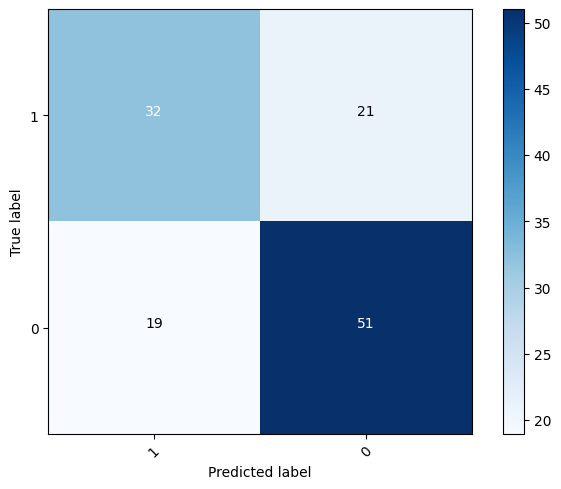

In [42]:
plot_cm('theta', 'central', 'valence', 'knn')

[[42 11]
 [27 43]]
              precision    recall  f1-score   support

           0       0.61      0.79      0.69        53
           1       0.80      0.61      0.69        70

    accuracy                           0.69       123
   macro avg       0.70      0.70      0.69       123
weighted avg       0.72      0.69      0.69       123


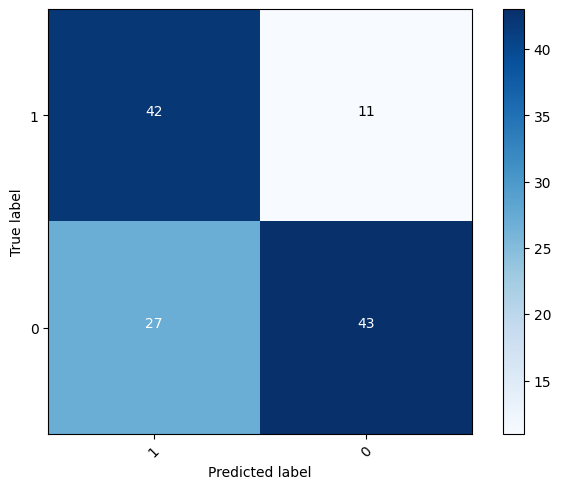

In [43]:
plot_cm('beta', 'left', 'valence', 'knn')

[[33 20]
 [19 51]]
              precision    recall  f1-score   support

           0       0.63      0.62      0.63        53
           1       0.72      0.73      0.72        70

    accuracy                           0.68       123
   macro avg       0.68      0.68      0.68       123
weighted avg       0.68      0.68      0.68       123


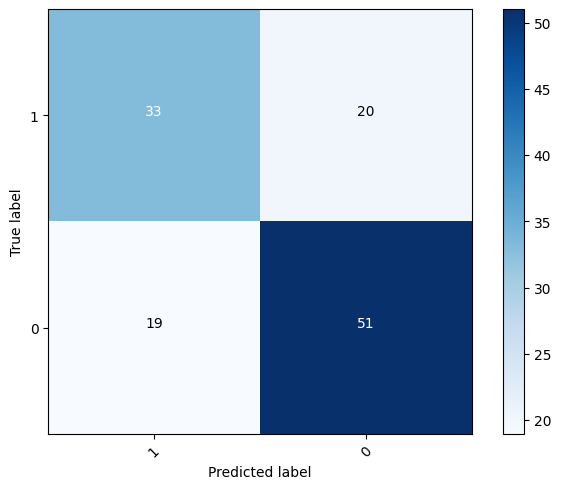

In [44]:
plot_cm('gamma', 'right', 'valence', 'knn')

#### Top combinations for Arousal

[[23 38]
 [14 48]]
              precision    recall  f1-score   support

           0       0.62      0.38      0.47        61
           1       0.56      0.77      0.65        62

    accuracy                           0.58       123
   macro avg       0.59      0.58      0.56       123
weighted avg       0.59      0.58      0.56       123


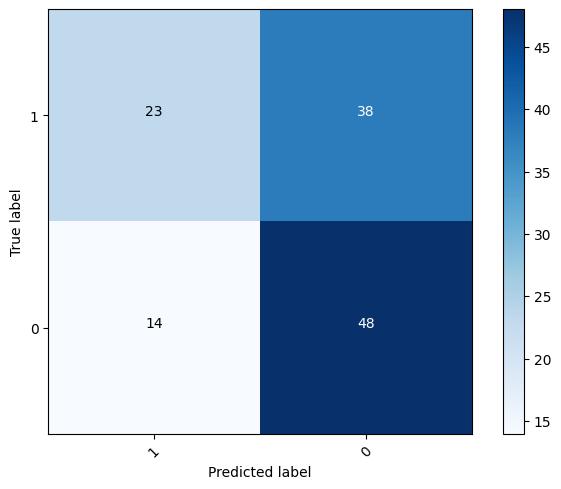

In [45]:
plot_cm('alpha', 'central', 'arousal', 'mlp')

[[26 35]
 [15 47]]
              precision    recall  f1-score   support

           0       0.63      0.43      0.51        61
           1       0.57      0.76      0.65        62

    accuracy                           0.59       123
   macro avg       0.60      0.59      0.58       123
weighted avg       0.60      0.59      0.58       123


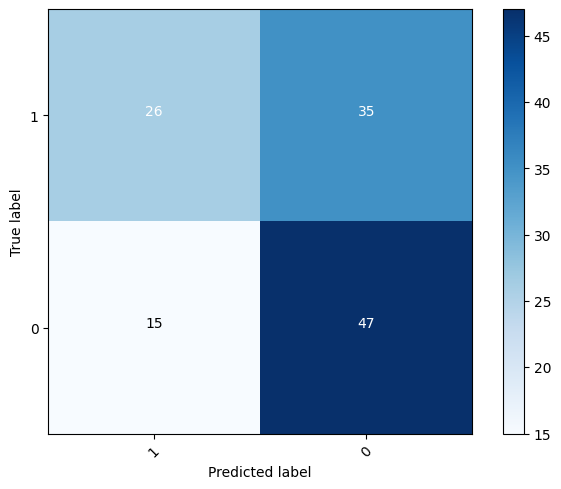

In [46]:
plot_cm('theta', 'parietal', 'arousal', 'mlp')

[[27 34]
 [26 36]]
              precision    recall  f1-score   support

           0       0.51      0.44      0.47        61
           1       0.51      0.58      0.55        62

    accuracy                           0.51       123
   macro avg       0.51      0.51      0.51       123
weighted avg       0.51      0.51      0.51       123


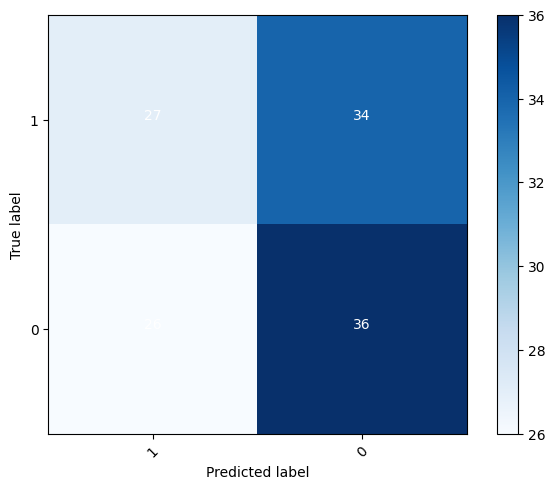

In [47]:
plot_cm('beta', 'frontal', 'arousal', 'mlp')